In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [113]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [13]:
%matplotlib inline

import os
import h5py
import json
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
# importing rastermap
# (this will be slow the first time since it is compiling the numba functions)
#from rastermap import Rastermap, utils
from scipy.stats import zscore
from scipy import stats as scipystats
from sklearn import decomposition

from utils.states import get_state_as_periods
from utils.neurosuite import get_unit_names_sorted
from utils.behavior import get_idxs_as_periods

#from utils.events import get_sound_event_periods

In [233]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

#session = '013608_ppcSIT_2025-01-06_13-20-52'  # PPC
session = '013608_ppcSIT_2025-01-14_10-20-14'  # HPC
#session = '013608_ppcSIT_2025-01-15_14-56-18'  # HPC
#session = '013608_ppcSIT_2025-01-16_09-49-21'  # PPC
#session = '013608_ppcSIT_2025-01-17_10-07-00' # PPC
#session = '013608_ppcSIT_2025-01-20_09-38-20'  # HPC
#session = '013608_ppcSIT_2025-01-21_08-50-02'  # Thalamus
#session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
#session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC

animal     = session.split('_')[0]
s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(source, animal, session, 'meta.h5')
units_file = os.path.join(source, animal, session, 'units.h5')
phsl_file  = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')

In [234]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
        
spike_times_all = spike_times.copy()

In [235]:
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]
speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]

speed_max = 0.04
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

# success stays
idxs_tgt_succ = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

In [236]:
# MRL
MRL_mx = np.zeros([len(unit_names), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_names):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [237]:
# mean firing rate
FR_mx = np.zeros([len(unit_names), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_names):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

In [254]:
# special units 
special = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198'],
    '013608_ppcSIT_2025-01-15_14-56-18': ['2-166', '2-288', '3-258', '4-231'],
    '013608_ppcSIT_2025-01-20_09-38-20': ['2-160', '2-241', '3-221', '4-201'],
    '013608_ppcSIT_2025-01-17_10-07-00': []
}

# or special units
# special['013608_ppcSIT_2025-01-14_10-20-14'] = special['013608_ppcSIT_2025-01-14_10-20-14'] + \
#     ['2-432', '3-296', '4-338', '3-330', '3-279', '3-436', '1-107', '2-304',\
#             '3-34', '3-265', '1-165', '2-478', '2-420', '4-302', '1-427', '1-459',\
#             '3-127', '3-88', '4-261', '3-62', '4-51', '1-441', '2-83', '4-200', \
#             '2-435', '3-332', '3-63', '3-271', '4-319', '2-28', '3-74', '3-280', \
#             '1-121', '4-322', '3-389', '3-33', '1-147', '1-449', '3-76', '1-440', \
#             '1-442', '1-482', '1-450', '4-90', '3-6', '4-212', '2-123', '1-139', \
#             '4-262', '4-37']

# exclude some?
#for unit in special['013608_ppcSIT_2025-01-14_10-20-14']:
#    spike_times.pop(unit)

idxs_special = [unit_names.index(x) for x in special[session]]
print(f"{len(idxs_special)} units to be excluded as special")

# MRL criteria
pv_min = 0.5
MRL_min = 0.03
MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_names)} units > 0.5Hz firing rate")
    
# MRL
idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 0] < MRL_min)[0]

idxs_MRL_high = np.intersect1d(idxs_mfr_min, idxs_MRL_high)
#idxs_MRL_high = np.setdiff1d(idxs_MRL_high, idxs_special)

idxs_MRL_low = np.intersect1d(idxs_mfr_min, idxs_MRL_low)
idxs_MRL_low = np.setdiff1d(idxs_MRL_low, idxs_special)

idxs_mfr_spc = np.setdiff1d(idxs_mfr_min, idxs_special)

idxs_final_filt = idxs_mfr_spc
spike_times = {}
unit_ids = [unit_names[x] for x in idxs_final_filt]



for unit_id in unit_ids:
    spike_times[unit_id] = spike_times_all[unit_id]

print(f"{len(idxs_MRL_high)} units with phase locking")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")
print(f"{len(unit_ids)} units selected")

4 units to be excluded as special
156 out of 213 units > 0.5Hz firing rate
92 units with phase locking
34 units have kind of no phase locking
152 units selected


### periods of stationarity / running

In [242]:
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
tgt_succ_pos_mx = np.zeros([len(tgt_mx_succ), 4])
for i, tgt_rec in enumerate(tgt_mx_succ):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_pos_mx[i] = [tgt_rec[0], tgt_rec[1], x_pos.mean(), y_pos.mean()]
    
bgr_sta_long_mx, idxs_bgr_sta_long = get_state_as_periods(s_path, 'BGR', 'STA', None, 11, strip_l=0)
sil_sta_long_mx, idxs_sil_sta_long = get_state_as_periods(s_path, 'SIL', 'STA', None, 11, strip_l=0)
#bgr_sta_AL_mx, idxs_bgr_sta_AL = get_state_as_periods(s_path, 'BGR', 'STA', 'AL', 12)
len(idxs_bgr_sta_long), len(idxs_sil_sta_long), len(idxs_bgr_sta_AL)

(498, 469, 241)

## Same locations in TGT / SIL on the manifold

In [29]:
tgt_succ_xy = np.zeros([len(tgt_mx_succ), 2])

for i, tgt_rec in enumerate(tgt_mx[tgt_mx[:, 4] == 1]):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_xy[i] = [x_pos.mean(), y_pos.mean()]

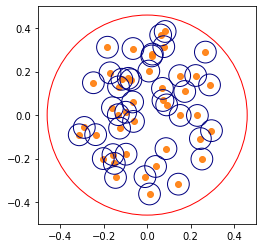

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(tgt_succ_xy[:, 0], tgt_succ_xy[:, 1], color='tab:orange', alpha=0.92)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal')

# arena
arena = plt.Circle((0, 0), 0.46, color='r', fill=False)
ax.add_patch(arena)

# visits
r_max = 0.05  # in meters
for tgt_xy in tgt_succ_xy:
    visit = plt.Circle((tgt_xy[0], tgt_xy[1]), r_max, color='navy', fill=False)
    ax.add_patch(visit)

plt.show()

## Unit activity matrix

In [243]:
# unit activity matrix
unit_mx_database = {}

In [244]:
# OPTION 1 - sound events binning
t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

unit_mx = zscore(unit_mx, axis=1)
unit_mx_database[1] = unit_mx.T.copy()

unit_mx.shape

(102, 9599)

In [245]:
# OPTION 2 - few sound events unwrapped in the future
unwrap_count = 1  # plus one more event

t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])  # units, sound events
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)
unit_mx = zscore(unit_mx, axis=1)  # sound events, units

res = unit_mx.copy()
for i in range(unwrap_count):
    res = np.vstack([res, np.roll(unit_mx, -i-1)])  # should be - ?

unit_mx_database[2] = res.T.copy()

unit_mx.shape, res.shape

((102, 9599), (204, 9599))

In [246]:
# OPTION 3 - mean of two sound events
t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

ev_count = unit_mx.shape[1]
if ev_count % 2 > 0:
    unit_mx = unit_mx[:, :ev_count-1]

mx_even = unit_mx.T[::2]
mx_odd  = unit_mx.T[1::2]

unit_mx = ((mx_even + mx_odd)/2).T
unit_mx = zscore(unit_mx, axis=1)
unit_mx_database[3] = unit_mx.T.copy()

# reshape to event size!!

unit_mx.shape

(102, 4799)

In [247]:
# OPTION 4 - 50ms binning
bin_size = 0.05
bins_to_add = int(0.25/bin_size) - 1

t_bins = sound_events[:, 0]
res = t_bins.copy()
for i in range(bins_to_add):
    res = np.vstack([res, t_bins + (i+1) * bin_size])

t_bins = res.T.flatten()

unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)
unit_mx = zscore(unit_mx, axis=1)

# reshape to event size!!
unwrap_count = 4
res = unit_mx.copy()
for i in range(unwrap_count):
    res = np.vstack([res, np.roll(unit_mx, -i-1)])  # should be - ?

unit_mx_database[4] = res.T[::5].copy()

unit_mx_database[4].T.shape

(510, 9600)

## TGT - TGT correlations

In [248]:
# 1 - just the first pulse
# 2 - the whole 6 seconds flattened?
# 3 micro flattened?

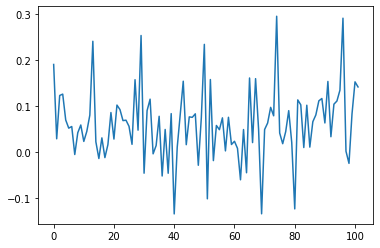

In [249]:
# PCA on TGT only
unit_mx = unit_mx_database[1]
unit_mx_tgt = unit_mx[idxs_tgt_succ]
ev_pca = decomposition.PCA(n_components=2)
ev_X   = ev_pca.fit_transform(unit_mx_tgt)
plt.plot(ev_pca.components_[0])

### Correlation within each TGT - sliding window

In [380]:
unit_mx = unit_mx_database[2]

corr_pulse_count = 3
pulses_rel = [x for x in range(-15, 40)]
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
pca_eigen = ev_pca.components_[0]  # set to 1 to avoid

tgt_within_prog = np.zeros([len(tgt_mx_succ), len(pulses_rel)])
for i, tgt_rec in enumerate(tgt_mx_succ):
    v_corr = np.zeros(len(pulses_rel))
    for j, offset in enumerate(pulses_rel):
        coeffs = []
        combs = list(itertools.combinations(range(corr_pulse_count), 2))  # combinations of vector IDs
        for idx_1, idx_2 in combs:
            v1 = unit_mx[tgt_rec[0] + idx_1 + offset]# * pca_eigen
            v2 = unit_mx[tgt_rec[0] + idx_2 + offset]# * pca_eigen
            coeffs.append(np.corrcoef(v1, v2)[0][1])
        v_corr[j] = np.median(np.array(coeffs))
    tgt_within_prog[i] = v_corr

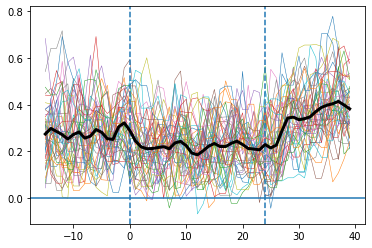

In [381]:
fig, ax = plt.subplots(1, 1)
for tgt_prog in tgt_within_prog:
    ax.plot(pulses_rel, tgt_prog, lw=0.5)
ax.axhline(0)
ax.axvline(0, ls='--')
ax.axvline(24, ls='--')
ax.plot(pulses_rel, tgt_within_prog.mean(axis=0), lw=3, color='black')

### Correlation within TGT - single pulses

In [386]:
unit_mx = unit_mx_database[1]

pulse_idx = 10  # idx of the pulse to correlate with within the TGT
pulses_rel = [x for x in range(-20, 40)]

# fake
fake_count = 30
idxs_vectors_ev = [random.randint(0 - pulses_rel[0], len(unit_mx) - pulses_rel[-1]) for x in range(fake_count)]

# success targets
idxs_vectors_ev = tgt_mx[tgt_mx[:, 4] == 1][:, 0]

# long stays
# min_dur_ev = 12
# per_mx = period_matrices['BGR_long_stays']
# idxs_vectors_ev = per_mx[np.where(per_mx[:, 1] - per_mx[:, 0] > min_dur_ev)[0]][:, 0].astype(np.int32)

idxs_vectors_ev = idxs_vectors_ev[idxs_vectors_ev + pulses_rel[-1] < len(unit_mx)]

pca_eigen = ev_pca.components_[0]  # set to 1 to avoid

tgt_within_prog = np.zeros([len(idxs_vectors_ev), len(pulses_rel)])
for i, idx_v_ev in enumerate(idxs_vectors_ev):
    v1 = unit_mx[idx_v_ev + pulse_idx] * pca_eigen
    
    v_corr = np.zeros(len(pulses_rel))
    for j, offset in enumerate(pulses_rel):
        v2 = unit_mx[idx_v_ev + offset] * pca_eigen
        v_corr[j] = np.corrcoef(v1, v2)[0][1]
        
    tgt_within_prog[i] = v_corr

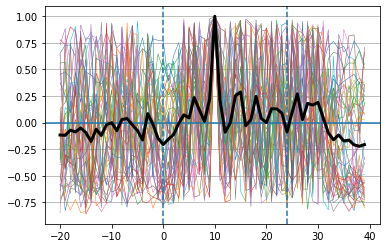

In [387]:
fig, ax = plt.subplots(1, 1)
for tgt_prog in tgt_within_prog:
    ax.plot(pulses_rel, tgt_prog, lw=0.5)
ax.axhline(0)
ax.axvline(0, ls='--')
ax.axvline(24, ls='--')
ax.plot(pulses_rel, tgt_within_prog.mean(axis=0), lw=3, color='black')
ax.grid(axis='y')

### Correlation progression between TGTs

In [77]:
# unit_mx = unit_mx_database[1]
# idxs_vectors_ev = tgt_mx_succ[:, 0]

# pca_eigen = ev_pca.components_[0]  # set to 1 to avoid
# corr_medians = []
# pulses_rel = [x for x in range(-15, 40)]
# for offset in pulses_rel:
#     corr_mx_t = np.zeros([len(idxs_vectors_ev), len(idxs_vectors_ev)])
#     for i, idx_1 in enumerate(idxs_vectors_ev):
#         for j, idx_2 in enumerate(idxs_vectors_ev):
#             v1 = unit_mx[idx_1+offset] #* pca_eigen
#             v2 = unit_mx[idx_2+offset] #* pca_eigen
#             corr_mx_t[i][j] = np.corrcoef(v1, v2)[0][1]
            
#     corrs = corr_mx_t.flatten()
#     corrs = corrs[corrs < 0.9]
#     corr_medians.append(np.median(corrs))

In [250]:
unit_mx   = unit_mx_database[1]

event_matrices = {
    'tgt_succ_pos_mx': tgt_succ_pos_mx,
    'bgr_sta_long_mx': bgr_sta_long_mx,
    'sil_sta_long_mx': sil_sta_long_mx,
}
offsets = {
    'tgt_succ_pos_mx': [x for x in range(-15, 40)],
    'bgr_sta_long_mx': [x for x in range(-15, 14)],
    'sil_sta_long_mx': [x for x in range(-15, 14)],
}
colors = {
    'tgt_succ_pos_mx': 'tab:orange',
    'bgr_sta_long_mx': 'tab:blue',
    'sil_sta_long_mx': 'grey',
}
labels = {
    'tgt_succ_pos_mx': 'Target',
    'bgr_sta_long_mx': 'Background',
    'sil_sta_long_mx': 'No stimulus',
}

In [251]:
#pca_eigen = ev_pca.components_[0]  # set to 1 to avoid
corr_matrices = {}  # to fill in
for mx_name, event_mx in event_matrices.items():
    corr_mx = []
    combs = list(itertools.combinations(range(len(event_mx)), 2))  # combinations of vector IDs
    pulses_rel = offsets[mx_name]
    idxs_event_onset = event_mx[:, 0].astype(np.int32)
    
    if not mx_name.find('tgt') >= 0:
        idxs_event_onset -= 2  # shift onset for BGR / SIL to align speeds
    
    for offset in pulses_rel:
        for idx_1, idx_2 in combs:
            v1 = unit_mx[idxs_event_onset[idx_1] + offset]
            v2 = unit_mx[idxs_event_onset[idx_2] + offset]

            corr = np.corrcoef(v1, v2)[0][1]
            dist = np.sqrt( (event_mx[idx_1][2] - event_mx[idx_2][2])**2 + (event_mx[idx_1][3] - event_mx[idx_2][3])**2 )
            time = np.abs(event_mx[idx_2][0] - event_mx[idx_1][0]) / 4  # in seconds

            # offset, corr coeff, dist b/w targets, time b/w targets
            corr_mx.append(np.array([offset, corr, dist, time]))
    corr_matrices[mx_name] = np.array(corr_mx)
    print(f"{mx_name} - done")

tgt_succ_pos_mx - done
bgr_sta_long_mx - done
sil_sta_long_mx - done


In [252]:
# speed at onsets
speed_mx = {}
for mx_name, event_mx in event_matrices.items():
    idxs_event_onset = event_mx[:, 0].astype(np.int32)
    
    if not mx_name.find('tgt') >= 0:
        idxs_event_onset -= 2  # shift onset for BGR / SIL to align speeds
        
    curr_offs = offsets[mx_name]
    speed_profiles = []
    for idx_event_onset in idxs_event_onset:
        idx_l = idx_event_onset + curr_offs[0]
        idx_r = idx_event_onset + curr_offs[-1]
        if idx_l < 0 or idx_r+1 >= len(speed_ev):
            continue
        speed_profiles.append( speed_ev[idx_l:idx_r+1] )
    speed_mx[mx_name] = np.array(speed_profiles).mean(axis=0)

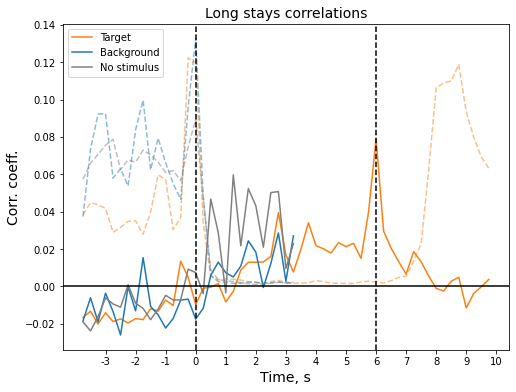

In [253]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for mx_name, corr_mx in corr_matrices.items():
    pulses_rel = offsets[mx_name]
    corr_medians = [np.median(corr_mx[corr_mx[:, 0] == offset][:, 1]) for offset in pulses_rel]
    ax.plot(pulses_rel, corr_medians, color=colors[mx_name], label=labels[mx_name])
    
    ax.plot(pulses_rel, speed_mx[mx_name]/2, color=colors[mx_name], ls='--', alpha=0.5)

ax.axhline(0, color='black')
ax.axvline(0, ls='--', color='black')
ax.axvline(24, ls='--', color='black')
ax.set_xticks(np.arange(-12, 41, 4))
ax.set_xticklabels((np.arange(-12, 41, 4)/4).astype(np.int32))
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Corr. coeff.', fontsize=14)
ax.set_title('Long stays correlations', fontsize=14)
ax.legend()

### Single timepoint

In [276]:
unit_mx = unit_mx_database[2]
offset = 20  # in sound events

idxs_vectors_ev = tgt_mx_succ[:, 0]

corr_mx = np.zeros([len(idxs_vectors_ev), len(idxs_vectors_ev)])
for i, idx_1 in enumerate(idxs_vectors_ev):
    for j, idx_2 in enumerate(idxs_vectors_ev):
        corr_mx[i][j] = np.corrcoef(unit_mx[idx_1+offset], unit_mx[idx_2+offset])[0][1]

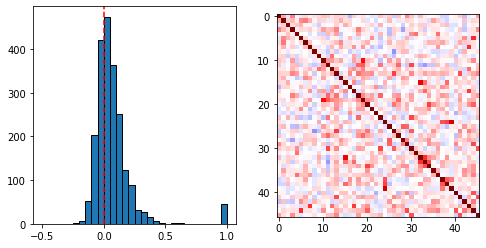

In [277]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

bins = np.linspace(-0.5, 1, 31)
axes[0].hist(corr_mx.flatten(), bins=bins, edgecolor='black')
axes[0].axvline(0, ls='--', color='red')
axes[1].imshow(corr_mx, cmap='seismic', vmin=-1, vmax=1)
plt.show()

In [113]:
from correlation import cluster_corr

corr_srt, Z, labels, idxs_sort = cluster_corr(corr_mx, threshold=2.0)
labels_dict = dict([(u, l) for u, l in zip(idxs_vectors_ev, labels)])

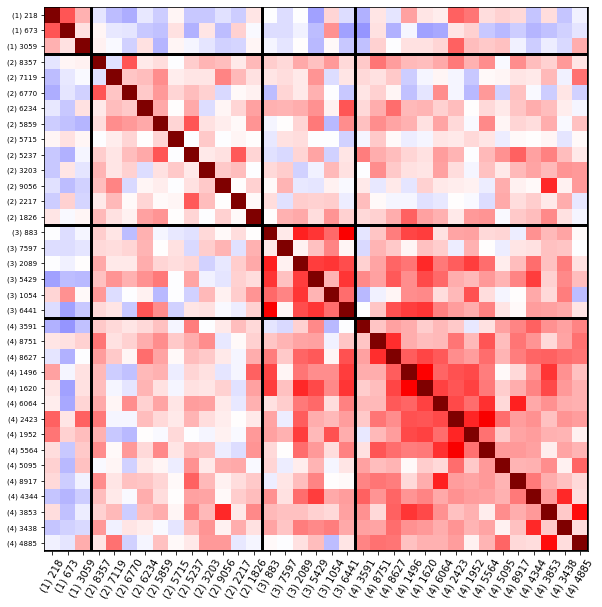

In [114]:
tick_labels = ["(%s) %s" % (labels_dict[u], u) for u in idxs_vectors_ev[idxs_sort]]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(corr_srt, cmap='seismic', vmin=-1, vmax=1)
ax.set_xticks(range(corr_srt.shape[0]))
ax.set_xticklabels(tick_labels, rotation=60)
ax.set_yticks(range(corr_srt.shape[0]))
_ = ax.set_yticklabels(tick_labels, fontsize=7)
for clu_no in set(labels):
    l_pos = np.where(labels[idxs_sort] == clu_no)[0][-1] + 0.5
    ax.axhline(l_pos, color='black', lw=3)
    ax.axvline(l_pos, color='black', lw=3)

plt.show()

In [115]:
# correlation vs distance in space and time
tgt_succ_xy.shape, corr_mx.shape

((35, 2), (35, 35))

In [174]:
dist_mx = np.zeros([len(idxs_vectors_ev), len(idxs_vectors_ev)])
time_mx = np.zeros([len(idxs_vectors_ev), len(idxs_vectors_ev)])
for i, idx_1 in enumerate(idxs_vectors_ev):
    for j, idx_2 in enumerate(idxs_vectors_ev):
        dist_mx[i][j] = np.sqrt( (tgt_succ_xy[i][0] - tgt_succ_xy[j][0])**2 + (tgt_succ_xy[i][1] - tgt_succ_xy[j][1])**2 )
        time_mx[i][j] = np.abs(idx_2 - idx_1) / 4  # in seconds

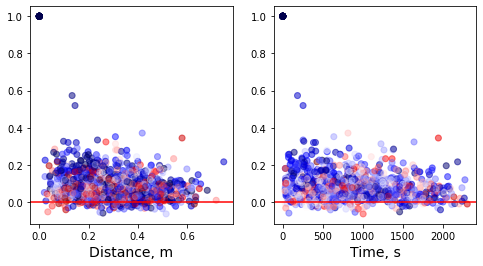

In [175]:
corr_mx_f = corr_mx.flatten()
dist_mx_f = dist_mx.flatten()
time_mx_f = time_mx.flatten()
idxs_filt = np.where(corr_mx_f < 0.9)[0]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.scatter(dist_mx.flatten(), corr_mx.flatten(), c=time_mx.flatten(), cmap='seismic', alpha=0.3)
ax.axhline(0, color='red')
ax.set_xlabel('Distance, m', fontsize=14)
d_slope, d_intercept, _, d_p_value, _ = scipystats.linregress(dist_mx_f[idxs_filt], corr_mx_f[idxs_filt])

ax = axes[1]
ax.scatter(time_mx.flatten(), corr_mx.flatten(), c=dist_mx.flatten(), cmap='seismic', alpha=0.3)
ax.axhline(0, color='red')
ax.set_xlabel('Time, s', fontsize=14)

t_slope, t_intercept, _, t_p_value, _ = scipystats.linregress(time_mx_f[idxs_filt], corr_mx_f[idxs_filt])

plt.show()

In [176]:
d_slope, d_p_value, t_slope, t_p_value

(-0.06758414040058736,
 4.4352574936299065e-10,
 -1.4912068614370698e-05,
 1.3153850991042118e-07)

## TGT visits

In [129]:
def get_idxs_as_periods(idxs_events):
    if len(idxs_events) == 0:
        return np.array([])
        
    idxs_to_idxs = np.where(np.diff(idxs_events) > 1)[0]
    if len(idxs_to_idxs) == 0:
        return np.array([idxs_events[0], idxs_events[-1]])
    
    # periods - indices to TL where was silent
    periods       = np.zeros([len(idxs_to_idxs) + 1, 2])
    periods[0]    = np.array([0, idxs_to_idxs[0]])
    periods[1:-1] = np.column_stack([idxs_to_idxs[:-1] + 1, idxs_to_idxs[1:]])
    periods[-1]   = np.array([idxs_to_idxs[-1]+1, len(idxs_events) - 1])
    periods       = periods.astype(np.int32)
    
    periods_ev = []
    for per in periods:
        periods_ev.append([idxs_events[per[0]], idxs_events[per[1]]])
    return np.array(periods_ev, dtype=np.int32)

In [14]:
r_max = 0.05  # in meters
min_ev_per_visit = 2

idxs_sil_sta = np.intersect1d(idxs_sil_ev, idxs_sta_ev)
idxs_bgr_sta = np.intersect1d(idxs_bgr_ev, idxs_sta_ev)

idxs_visits = {'SIL': [], 'BGR': []}  # visits as ranges of indices to sound events
titles = ['SIL', 'BGR']
for i, tgt_xy in enumerate(tgt_succ_xy):
    idxs_around_ev = np.where( (x_pos_ev - tgt_xy[0])**2 + (y_pos_ev - tgt_xy[1])**2 < r_max**2 )[0]
    idxs_around_sil_ev = np.intersect1d(idxs_around_ev, idxs_sil_sta)
    idxs_around_bgr_ev = np.intersect1d(idxs_around_ev, idxs_bgr_sta)

    for j, idxs_events in enumerate([idxs_around_sil_ev, idxs_around_bgr_ev]):
        idxs_coll = list(idxs_visits[titles[j]])
        idxs_sil_as_per = get_idxs_as_periods(idxs_events)
        if len(idxs_sil_as_per.shape) == 1:
            if np.diff(idxs_sil_as_per) > min_ev_per_visit - 2:
                idxs_coll.append([int(idxs_sil_as_per[0]), int(idxs_sil_as_per[1]), i])
        elif len(idxs_sil_as_per) > 1:
            idxs_sil_as_per = idxs_sil_as_per[np.where(np.diff(idxs_sil_as_per, axis=1) > min_ev_per_visit - 2)[0]]
            for per in idxs_sil_as_per:
                idxs_coll.append([int(per[0]), int(per[1]), i])

        idxs_visits[titles[j]] = np.array(idxs_coll, dtype=np.int32)

/var/folders/vg/h5spkjzx24b1c9zq02d9lv9h0000gn/T/ipykernel_15071/3832878943.py:18: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.diff(idxs_sil_as_per) > min_ev_per_visit - 2:


In [15]:
len(idxs_visits['SIL']), len(idxs_visits['BGR'])

(317, 226)

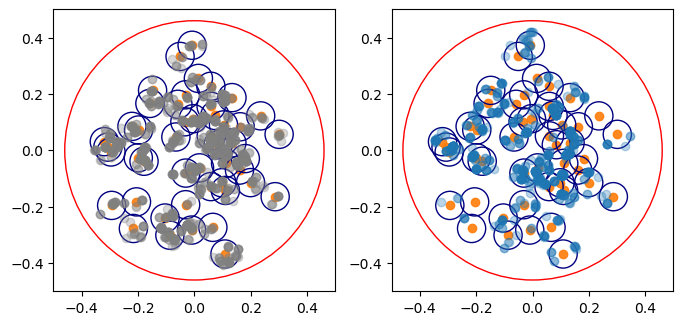

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

colors = ['grey', 'tab:blue']
for i, ax in enumerate(axes):
    ax.scatter(tgt_succ_xy[:, 0], tgt_succ_xy[:, 1], color='tab:orange', alpha=0.92)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_aspect('equal')
    
    # arena
    arena = plt.Circle((0, 0), 0.46, color='r', fill=False)
    ax.add_patch(arena)
    
    # visits - circles
    r_max = 0.05  # in meters
    for tgt_xy in tgt_succ_xy:
        visit = plt.Circle((tgt_xy[0], tgt_xy[1]), r_max, color='navy', fill=False)
        ax.add_patch(visit)
    
    # visits - events
    for visit in idxs_visits[titles[i]]:
        idxs_visit = np.arange(visit[0], visit[1])
        ax.scatter(x_pos_ev[idxs_visit], y_pos_ev[idxs_visit], color=colors[i], alpha=0.3)

#plt.show()

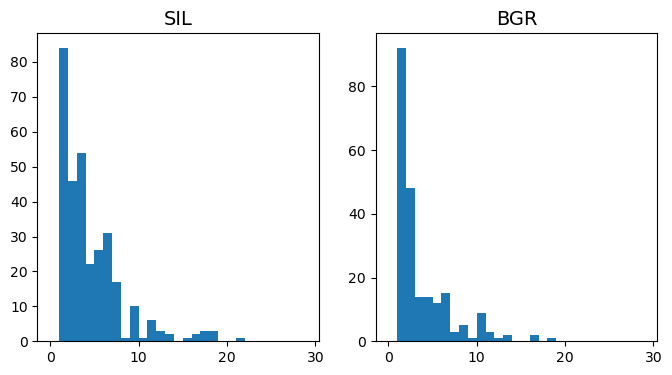

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

titles = ['SIL', 'BGR']
colors = ['grey', 'tab:blue']
for i, ax in enumerate(axes):
    visit_durations = np.diff(idxs_visits[titles[i]][:, :2], axis=1)
    ax.hist(visit_durations, bins=np.arange(0, 30))
    ax.set_title(titles[i], fontsize=14)

In [52]:
unit_mx = unit_mx_database[2]
offset = 0  # in sound events
condition = 'BGR'

idxs_vectors_ev = idxs_visits[condition][:, 0]

visit_corr_mx = np.zeros([len(idxs_vectors_ev), len(idxs_vectors_ev)])
for i, idx_1 in enumerate(idxs_vectors_ev):
    for j, idx_2 in enumerate(idxs_vectors_ev):
        visit_corr_mx[i][j] = np.corrcoef(unit_mx[idx_1+offset], unit_mx[idx_2+offset])[0][1]

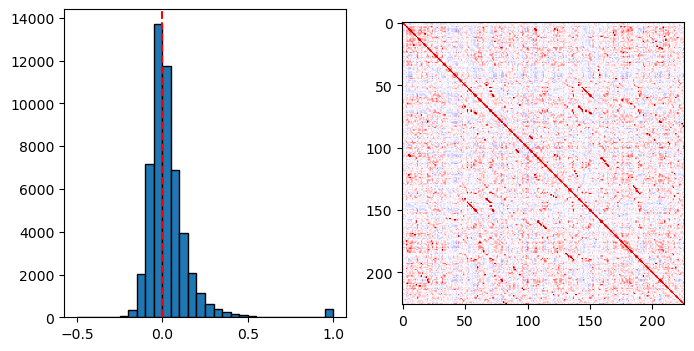

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

bins = np.linspace(-0.5, 1, 31)
axes[0].hist(visit_corr_mx.flatten(), bins=bins, edgecolor='black')
axes[0].axvline(0, ls='--', color='red')
axes[1].imshow(visit_corr_mx, cmap='seismic', vmin=-1, vmax=1)
plt.show()

In [54]:
from correlation import cluster_corr

corr_srt, Z, labels, idxs_sort = cluster_corr(visit_corr_mx, threshold=4.0)
labels_dict = dict([(u, l) for u, l in zip(idxs_vectors_ev, labels)])

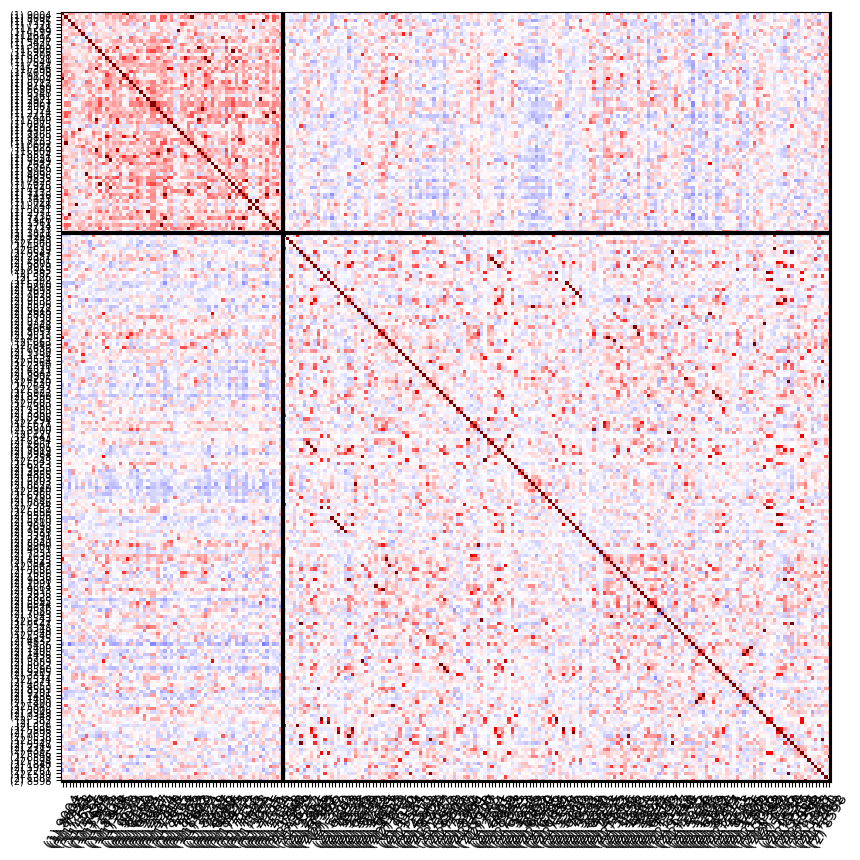

In [55]:
# TODO: find out why some visits cluster being highly correlated
tick_labels = ["(%s) %s" % (labels_dict[u], u) for u in idxs_vectors_ev[idxs_sort]]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(corr_srt, cmap='seismic', vmin=-1, vmax=1)
ax.set_xticks(range(corr_srt.shape[0]))
ax.set_xticklabels(tick_labels, rotation=60)
ax.set_yticks(range(corr_srt.shape[0]))
_ = ax.set_yticklabels(tick_labels, fontsize=7)
for clu_no in set(labels):
    l_pos = np.where(labels[idxs_sort] == clu_no)[0][-1] + 0.5
    ax.axhline(l_pos, color='black', lw=3)
    ax.axvline(l_pos, color='black', lw=3)

In [56]:
visit_xy = np.zeros([len(idxs_visits[condition]), 2])

for i, visit_rec in enumerate(idxs_visits[condition]):
    x_pos = x_pos_ev[np.arange(visit_rec[0], visit_rec[1])]
    y_pos = y_pos_ev[np.arange(visit_rec[0], visit_rec[1])]
    
    visit_xy[i] = [x_pos.mean(), y_pos.mean()]

In [57]:
visits_dist_mx = np.zeros([len(idxs_visits[condition]), len(idxs_visits[condition])])
visits_time_mx = np.zeros([len(idxs_visits[condition]), len(idxs_visits[condition])])
for i, idx_1 in enumerate(idxs_visits[condition][:, 0]):
    for j, idx_2 in enumerate(idxs_visits[condition][:, 0]):
        visits_dist_mx[i][j] = np.sqrt( (visit_xy[i][0] - visit_xy[j][0])**2 + (visit_xy[i][1] - visit_xy[j][1])**2 )
        visits_time_mx[i][j] = np.abs(idx_2 - idx_1) / 4  # in seconds

In [58]:
means, medians, stds, stde, intervals = [], [], [], [], []

dist_bins = np.linspace(0, visits_dist_mx.max(), 10)
time_bins = np.linspace(0, visits_time_mx.max(), 10)

visits_dist_mx_flat = visits_dist_mx.flatten()
visits_time_mx_flat = visits_time_mx.flatten()
visit_corr_mx_flat = visit_corr_mx.flatten()

for i in range(len(dist_bins) - 1):
    idxs = np.where((visits_dist_mx_flat > dist_bins[i]) & (visits_dist_mx_flat < dist_bins[i+1]))[0]
    k_slice = visit_corr_mx_flat[idxs]

    means.append(np.mean(k_slice))
    medians.append(np.median(k_slice))
    stds.append(np.std(k_slice))
    stde.append(scipystats.sem(k_slice))

    j_min, j_max = scipystats.t.interval(0.95, len(k_slice)-1, loc=np.median(k_slice), scale=scipystats.sem(k_slice))
    intervals.append([j_min, j_max])

Text(0.5, 0, 'Time, s')

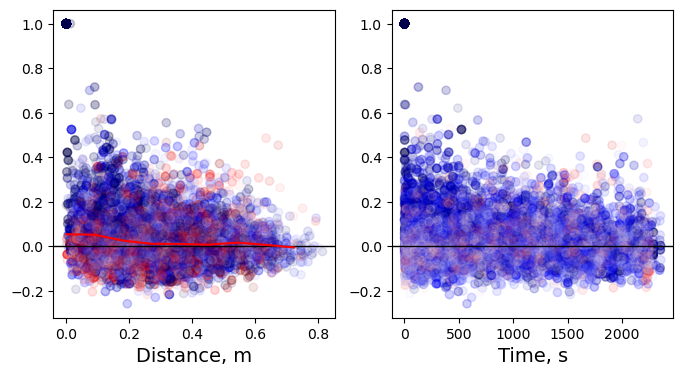

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.scatter(visits_dist_mx.flatten(), visit_corr_mx.flatten(), c=visits_time_mx.flatten(), cmap='seismic', alpha=0.05)
ax.axhline(0, color='black', lw=1)
ax.set_xlabel('Distance, m', fontsize=14)
ax.plot(dist_bins[:-1], means, color='red')

ax = axes[1]
ax.scatter(visits_time_mx.flatten(), visit_corr_mx.flatten(), c=visits_dist_mx.flatten(), cmap='seismic', alpha=0.05)
ax.axhline(0, color='black', lw=1)
ax.set_xlabel('Time, s', fontsize=14)

In [ ]:
# Control: select random stays for 6 seconds and show that population vectors do not drift 
# the same as in TGT

In [61]:
# correlate pop vectors between visits and corresponding targets
# - in the beg of the target
# - at the end of target

In [16]:
unit_mx = unit_mx_database[2]
offset = 20  # in sound events
condition = 'SIL'

idxs_tgt_vectors_ev = tgt_mx_succ[:, 0]  # first pulse in TGT
idxs_vis_vectors_ev = idxs_visits[condition][:, 0]  # first pulse in visit

tgt_visit_corr_mx = np.zeros([len(idxs_vis_vectors_ev), 3])  # corr at the beg of TGT, at the end of TGT, diff in time
for i, visit in enumerate(idxs_visits[condition]):
    idx_tgt_ev = tgt_mx_succ[visit[2]][0]
    idx_vis_ev = visit[0]
    
    coeff_beg = np.corrcoef(unit_mx[idx_tgt_ev], unit_mx[idx_vis_ev])[0][1]
    coeff_end = np.corrcoef(unit_mx[idx_tgt_ev + offset], unit_mx[idx_vis_ev])[0][1]
    time_diff = np.abs(idx_tgt_ev - idx_vis_ev)/4
    
    tgt_visit_corr_mx[i] = np.array([coeff_beg, coeff_end, time_diff])

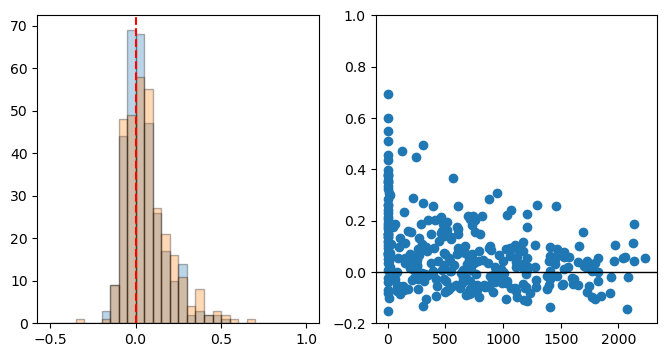

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

bins = np.linspace(-0.5, 1, 31)
ax = axes[0]
ax.hist(tgt_visit_corr_mx[:, 0], bins=bins, edgecolor='black', alpha=0.3)
ax.hist(tgt_visit_corr_mx[:, 1], bins=bins, edgecolor='black', alpha=0.3)
ax.axvline(0, ls='--', color='red')

ax = axes[1]
ax.scatter(tgt_visit_corr_mx[:, 2], tgt_visit_corr_mx[:, 1])
ax.axhline(0, color='black', lw=1)
ax.set_ylim(-0.2, 1)
plt.show()

In [19]:
# do shuffle target events / visits to look at shuffled correlations for all pop vector histograms

## Corrs within TGT

In [ ]:
# distance == time within TGT